In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import time
import scipy.stats as stats
from scipy.interpolate import griddata

In [2]:
import random
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:

columns = ['x', 'y', 'z', 'Bx', 'By', 'Bz']

df = pd.read_csv('COMSOL_B0.txt', skiprows=9, delim_whitespace=True,names=columns)
df.shape

(1185921, 6)

In [4]:
df.head(2)

,x,y,z,Bx,By,Bz
0,-0.300,-0.3,-0.2,-4.405221e-11,6.156934e-11,0.000001
1,-0.295,-0.3,-0.2,-4.127830e-11,5.914618e-11,0.000001


In [5]:
df[['Bx', 'By', 'Bz']] *=1e9
df.head(2)

,x,y,z,Bx,By,Bz
0,-0.300,-0.3,-0.2,-0.044052,0.061569,1021.295548
1,-0.295,-0.3,-0.2,-0.041278,0.059146,1021.297513


In [6]:
x_unique, x_min, x_max= df['x'].unique(), min(df['x']), max(df['x'])
print(len(x_unique), x_min, x_max)

121 -0.3 0.3


In [7]:
y_unique, y_min, y_max = df['y'].unique(), min(df['y']), max(df['y'])
print(len(y_unique), y_min, y_max)


121 -0.3 0.3


In [8]:
z_unique, z_min, z_max = df['z'].unique(), min(df['z']), max(df['z'])
print(len(z_unique), z_min, z_max)


81 -0.2 0.2


In [9]:
from scipy.interpolate import RegularGridInterpolator

df_sorted = df.sort_values(by=['x', 'y', 'z'])

x_sorted = np.unique(df_sorted['x'].values)
y_sorted = np.unique(df_sorted['y'].values)
z_sorted = np.unique(df_sorted['z'].values)

Bx_sorted = df_sorted['Bx'].values.reshape(len(x_sorted), len(y_sorted), len(z_sorted))
By_sorted = df_sorted['By'].values.reshape(len(x_sorted), len(y_sorted), len(z_sorted))
Bz_sorted = df_sorted['Bz'].values.reshape(len(x_sorted), len(y_sorted), len(z_sorted))

Bx_mean = Bx_sorted.mean()
Bx_std = Bx_sorted.std()
By_mean = By_sorted.mean()
By_std = By_sorted.std()
Bz_mean = Bz_sorted.mean()
Bz_std = Bz_sorted.std()

Bx_sorted = (Bx_sorted - Bx_mean) / Bx_std
By_sorted = (By_sorted - By_mean) / By_std
Bz_sorted = (Bz_sorted - Bz_mean) / Bz_std

Bx_interpolator = RegularGridInterpolator((x_sorted, y_sorted, z_sorted), Bx_sorted,  method='quintic')
By_interpolator = RegularGridInterpolator((x_sorted, y_sorted, z_sorted), By_sorted, method='quintic')
Bz_interpolator = RegularGridInterpolator((x_sorted, y_sorted, z_sorted), Bz_sorted, method='quintic')


In [10]:
new_points_df = pd.read_csv('testcylinder_xyz.csv')
new_points_df[['x', 'y', 'z']] /= 4

X_NEW = new_points_df['x'].values
Y_NEW = new_points_df['y'].values
Z_NEW = new_points_df['z'].values

points_new = np.stack((X_NEW, Y_NEW, Z_NEW), axis=-1)


Bx_new = Bx_interpolator(points_new)
By_new = By_interpolator(points_new)
Bz_new = Bz_interpolator(points_new)

Bx_new = Bx_new * Bx_std + Bx_mean
By_new = By_new * By_std + By_mean
Bz_new = Bz_new * Bz_std + Bz_mean

initial_df = pd.DataFrame({
    'x': X_NEW,
    'y': Y_NEW,
    'z': Z_NEW,
    'Bx': Bx_new,
    'By': By_new,
    'Bz': Bz_new})

mapper_df = pd.DataFrame({
    'mapper_x': X_NEW,
    'mapper_y': Y_NEW,
    'mapper_z': Z_NEW,
    'Bx': Bx_new,
    'By': By_new,
    'Bz': Bz_new})


In [11]:

mapper_unscaled_position = initial_df[['x', 'y', 'z']].copy()

print(mapper_unscaled_position.head())


          x             y     z
0 -0.144338 -1.767500e-17 -0.15
1 -0.135633 -4.936636e-02 -0.15
2 -0.142145 -2.506396e-02 -0.15
3 -0.125000 -7.216878e-02 -0.15
4 -0.110569 -9.277840e-02 -0.15


In [12]:
# if needed, add any level of noise , for mapper , like 0.1 nT?

In [13]:
width_mapper = 0
sigma_mapper = width_mapper / 3  
#sigma_mapper = 0
length = len(mapper_df)

gaussian_noise_mapper_Bx = np.random.normal(0, sigma_mapper, length)
gaussian_noise_mapper_By = np.random.normal(0, sigma_mapper, length)
gaussian_noise_mapper_Bz = np.random.normal(0, sigma_mapper, length)

mapper_noise_df = pd.DataFrame({
    'Bx_noise': gaussian_noise_mapper_Bx,
    'By_noise': gaussian_noise_mapper_By,
    'Bz_noise': gaussian_noise_mapper_Bz
})


mapper_df['Bx'] += gaussian_noise_mapper_Bx
mapper_df['By'] += gaussian_noise_mapper_By
mapper_df['Bz'] += gaussian_noise_mapper_Bz

# cloudy points for using physics equations 

In [14]:
x_min, x_max = -25, 25 
z_min, z_max = 5 , 15
x = np.linspace(x_min/100, x_max/100, 10)
y = np.linspace(x_min/100, x_max/100, 10)

z1 = np.linspace(z_min/100, z_max/100, 10)
z2 = np.linspace(-z_min/100, -z_max/100, 10)
z = np.concatenate([z1, z2])


X, Y, Z = np.meshgrid(x, y, z)


x_flat = X.flatten()
y_flat = Y.flatten()
z_flat = Z.flatten()

cloudy_coordinates_df = pd.DataFrame({'c_x': x_flat, 'c_y': y_flat, 'c_z': z_flat})

In [15]:

combined_x = pd.concat([mapper_df['mapper_x'], cloudy_coordinates_df['c_x']], ignore_index=True)
combined_y = pd.concat([mapper_df['mapper_y'], cloudy_coordinates_df['c_y']], ignore_index=True)
combined_z = pd.concat([mapper_df['mapper_z'], cloudy_coordinates_df['c_z']], ignore_index=True)

# normalizing input(x, y, z)
combined_x_normalized = (combined_x - combined_x.min()) / (combined_x.max() - combined_x.min())
combined_y_normalized = (combined_y - combined_y.min()) / (combined_y.max() - combined_y.min())
combined_z_normalized = (combined_z - combined_z.min()) / (combined_z.max() - combined_z.min())

n_mapper = len(mapper_df)

mapper_x_normalized = combined_x_normalized[:n_mapper]
mapper_y_normalized = combined_y_normalized[:n_mapper]
mapper_z_normalized = combined_z_normalized[:n_mapper]

cloudy_x_normalized = combined_x_normalized[n_mapper:]
cloudy_y_normalized = combined_y_normalized[n_mapper:]
cloudy_z_normalized = combined_z_normalized[n_mapper:]


combined_x_normalized_tensor = torch.tensor(combined_x_normalized.values).float().requires_grad_(True).unsqueeze(-1)
combined_y_normalized_tensor = torch.tensor(combined_y_normalized.values).float().requires_grad_(True).unsqueeze(-1)
combined_z_normalized_tensor = torch.tensor(combined_z_normalized.values).float().requires_grad_(True).unsqueeze(-1)

mapper_x_normalized_tensor = combined_x_normalized_tensor[:n_mapper]
mapper_y_normalized_tensor = combined_y_normalized_tensor[:n_mapper]
mapper_z_normalized_tensor = combined_z_normalized_tensor[:n_mapper]


cloudy_x_normalized_tensor = combined_x_normalized_tensor[n_mapper:]
cloudy_y_normalized_tensor = combined_y_normalized_tensor[n_mapper:]
cloudy_z_normalized_tensor = combined_z_normalized_tensor[n_mapper:]

combined_input_tensor = torch.cat((
    combined_x_normalized_tensor,
    combined_y_normalized_tensor,
    combined_z_normalized_tensor
), dim=1)


mapper_output = mapper_df[['Bx', 'By', 'Bz']].values
mapper_output_tensor = torch.from_numpy(mapper_output).float()

mapper_Bx = mapper_output_tensor[:, 0].unsqueeze(-1)
mapper_By = mapper_output_tensor[:, 1].unsqueeze(-1)
mapper_Bz = mapper_output_tensor[:, 2].unsqueeze(-1)

# architecture of the model
class PINNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3, 48)
        self.fc2 = nn.Linear(48, 32)
        self.fc3 = nn.Linear(32, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mapper_B = self.fc3(x)
        return mapper_B


model = PINNModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training 
del_dot_B = []  
del_dot_B_loss = []  
del_cross_B = []  
del_cross_B_loss = []  
mapper_loss = []
opm_loss = []
hg_loss = []
chi_square = []
physics_losses = []
start_time = time.time()
time_taken = []
epochs = 8200
mapper_regularization = 1
opm_regularization = 1
hg_regularization= 1
del_dot_B_regularization = 1
del_cross_B_regularization = 1

for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    output_mapper = model(combined_input_tensor)
    
    Bx_physics = output_mapper[:, 0].unsqueeze(-1)
    By_physics = output_mapper[:, 1].unsqueeze(-1)
    Bz_physics = output_mapper[:, 2].unsqueeze(-1)
    
    num_mapper = mapper_x_normalized_tensor.shape[0]
    Bx_m = Bx_physics[:num_mapper]
    By_m = By_physics[:num_mapper]
    Bz_m = Bz_physics[:num_mapper]

    # Mapper losses
    loss_bx = criterion(Bx_m, mapper_Bx)
    loss_by = criterion(By_m, mapper_By)
    loss_bz = criterion(Bz_m, mapper_Bz)
    mapper_loss.append(loss_bx.item() + loss_by.item() + loss_bz.item())
    
    mse = mapper_regularization * (loss_bx + loss_by + loss_bz)
    
    # Physics losses
    n=1
    if epochs >= n:
        dBx_dx = torch.autograd.grad(Bx_physics, combined_x_normalized_tensor, torch.ones_like(Bx_physics), create_graph=True, allow_unused=True)[0]
        dBx_dy = torch.autograd.grad(Bx_physics, combined_y_normalized_tensor, torch.ones_like(Bx_physics), create_graph=True, allow_unused=True)[0]
        dBx_dz = torch.autograd.grad(Bx_physics, combined_z_normalized_tensor, torch.ones_like(Bx_physics), create_graph=True, allow_unused=True)[0]
        dBy_dx = torch.autograd.grad(By_physics, combined_x_normalized_tensor, torch.ones_like(By_physics), create_graph=True, allow_unused=True)[0]
        dBy_dy = torch.autograd.grad(By_physics, combined_y_normalized_tensor, torch.ones_like(By_physics), create_graph=True, allow_unused=True)[0]
        dBy_dz = torch.autograd.grad(By_physics, combined_z_normalized_tensor, torch.ones_like(By_physics), create_graph=True, allow_unused=True)[0]
        dBz_dx = torch.autograd.grad(Bz_physics, combined_x_normalized_tensor, torch.ones_like(Bz_physics), create_graph=True, allow_unused=True)[0]
        dBz_dy = torch.autograd.grad(Bz_physics, combined_y_normalized_tensor, torch.ones_like(Bz_physics), create_graph=True, allow_unused=True)[0]
        dBz_dz = torch.autograd.grad(Bz_physics, combined_z_normalized_tensor, torch.ones_like(Bz_physics), create_graph=True, allow_unused=True)[0]

        curl_Bx = dBz_dy - dBy_dz
        curl_By = dBx_dz - dBz_dx
        curl_Bz = dBy_dx - dBx_dy
        del_dot = dBx_dx + dBy_dy + dBz_dz

        del_dot_B.append(torch.mean(del_dot).detach().item())
        del_dot_B_loss_value = torch.mean((dBx_dx + dBy_dy + dBz_dz)**2).detach()
        del_dot_B_loss.append(del_dot_B_loss_value.item())

        del_cross = curl_Bx + curl_By + curl_Bz
        del_cross_b = torch.mean(del_cross).detach()
        del_cross_B.append(del_cross_b.item())
        del_cross_B_loss_value = (torch.mean((curl_Bx)**2) + torch.mean((curl_By)**2) + torch.mean((curl_Bz)**2)).detach()
        del_cross_B_loss.append(del_cross_B_loss_value.item())

        physics_loss = del_cross_B_regularization * del_cross_B_loss_value + del_dot_B_regularization * del_dot_B_loss_value
        loss = mse + physics_loss 
    else:
        loss = mse
    
    loss.backward()
    optimizer.step()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
    final_time = time.time()
    time_taken.append(final_time - start_time)


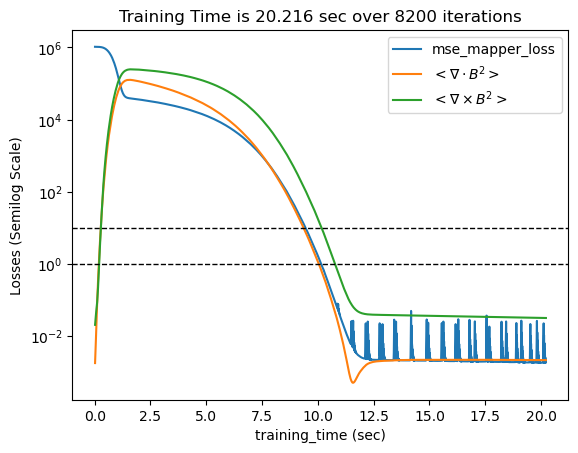

In [16]:
time_taken_trimmed = time_taken[:epochs] 
mapper_loss_trimmed = mapper_loss[:epochs]
plt.semilogy(time_taken_trimmed, mapper_loss_trimmed, label='mse_mapper_loss')
if n < epochs:
  
    plt.semilogy(time_taken_trimmed[n:], del_dot_B_loss[:epochs-n], label=fr'$<\nabla \cdot B^2>$ ')
    plt.semilogy(time_taken_trimmed[n:], del_cross_B_loss[:epochs-n], label=fr'$<\nabla \times B^2>$ ')

plt.xlabel('training_time (sec)')
plt.ylabel('Losses (Semilog Scale)')
plt.legend()
plt.title(f'Training Time is {time_taken_trimmed[-1]:.3f} sec over {epochs} iterations')

plt.axhline(1, color='k', linestyle='--', linewidth=1)
plt.axhline(10, color='k', linestyle='--', linewidth=1)
plt.show()

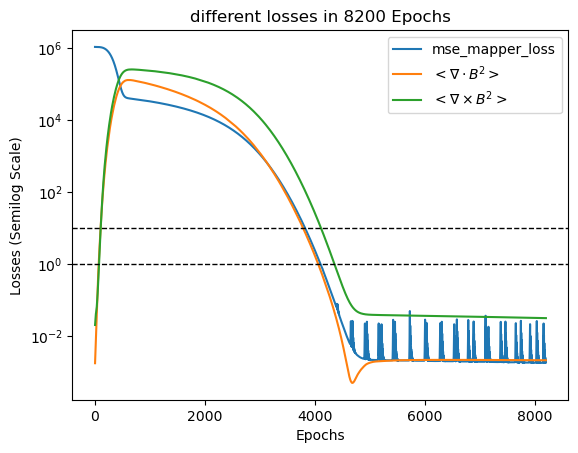

In [17]:
epochs_range = range(epochs)

mapper_loss_trimmed = mapper_loss[:epochs]
opm_loss_trimmed = opm_loss[:epochs]

plt.semilogy(epochs_range, mapper_loss_trimmed, label='mse_mapper_loss')

if n < epochs:
    plt.semilogy(range(n, epochs), del_dot_B_loss[:epochs-n], label=r'$<\nabla \cdot B^2>$')
    plt.semilogy(range(n, epochs), del_cross_B_loss[:epochs-n], label=r'$<\nabla \times B^2>$ ')

plt.xlabel('Epochs')
plt.ylabel('Losses (Semilog Scale)')
plt.legend()
plt.title(f'different losses in {epochs} Epochs')

plt.axhline(1, color='k', linestyle='--', linewidth=1)
plt.axhline(10, color='k', linestyle='--', linewidth=1)

plt.show()

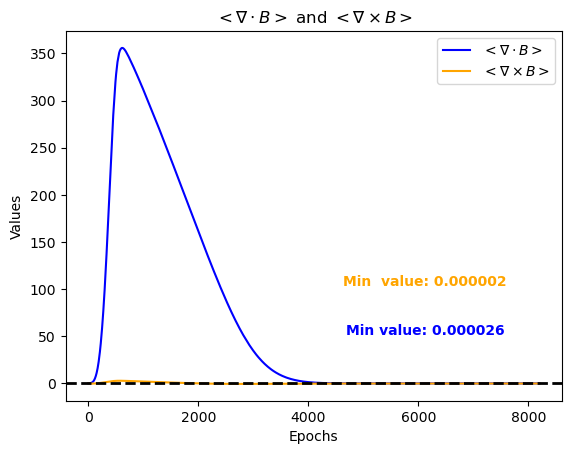

In [18]:
absolute_del_dot_B = [abs(val) for val in del_dot_B]
absolute_del_cross_B = [abs(val) for val in del_cross_B]

min_abs_del_dot_B = min(absolute_del_dot_B)
min_abs_del_cross_B = min(absolute_del_cross_B)


plt.plot(del_dot_B, label=r'$<\nabla \cdot B>$', color='blue')
plt.plot(del_cross_B, label=r'$<\nabla \times B>$', color='orange')
plt.axhline(0, color='black', linewidth=2, linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.title(r'$<\nabla \cdot B>$ and $<\nabla \times B>$')

min_del_dot_B_index = absolute_del_dot_B.index(min_abs_del_dot_B)
min_del_cross_B_index = absolute_del_cross_B.index(min_abs_del_cross_B)

plt.annotate(f'Min value: {min_abs_del_dot_B:.6f}', 
             xy=(min_del_dot_B_index, del_dot_B[min_del_dot_B_index]), 
             xytext=(0, 35), textcoords='offset points',
             fontweight='bold',color='blue')
             

plt.annotate(f'Min  value: {min_abs_del_cross_B:.6f}', 
             xy=(min_del_cross_B_index, del_cross_B[min_del_cross_B_index]), 
                          xytext=(105, 70), textcoords='offset points',
             fontweight='bold',color='orange')

plt.legend()

In [19]:

prediction_coordinate = torch.cat((mapper_x_normalized_tensor, mapper_y_normalized_tensor, mapper_z_normalized_tensor), dim=1)

model.eval()

with torch.no_grad():
    output = model(prediction_coordinate)

predicted = output.numpy()

predicted_df = pd.DataFrame(predicted, columns=['Bx', 'By', 'Bz'])


In [20]:
final_df = pd.concat([mapper_unscaled_position, predicted_df], axis=1)
final_df.shape

(540, 6)

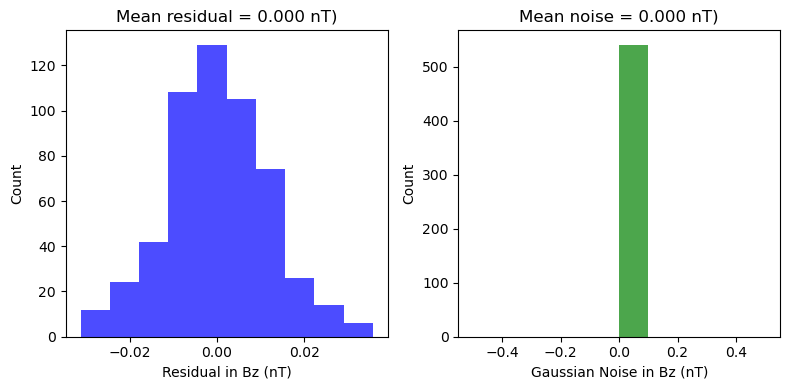

0.036 0.0 -0.031


In [21]:
components = ['Bz']
bin_count = 10  #

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

for i, comp in enumerate(components):

    residual_mean = (final_df[comp] - mapper_df[comp]).mean()
    noise_mean = mapper_noise_df[f'{comp}_noise'].mean()

    axs[0].hist(final_df[comp] - mapper_df[comp], bins=bin_count, color='blue', alpha=0.7)
    axs[0].set_xlabel(f"Residual in {comp} (nT)")
    axs[0].set_ylabel("Count")
    axs[0].set_title(f"Mean residual = {residual_mean:.3f} nT)")

 
    axs[1].hist(mapper_noise_df[f'{comp}_noise'], bins=bin_count, color='green', alpha=0.7)
    axs[1].set_xlabel(f"Gaussian Noise in {comp} (nT)")
    axs[1].set_ylabel("Count")
    axs[1].set_title(f"Mean noise = {noise_mean:.3f} nT)")

plt.tight_layout()
plt.show()
residual = final_df[comp] - mapper_df[comp]
print(round(np.max(residual), 3), round(np.mean(residual), 3), round(np.min(residual), 3))

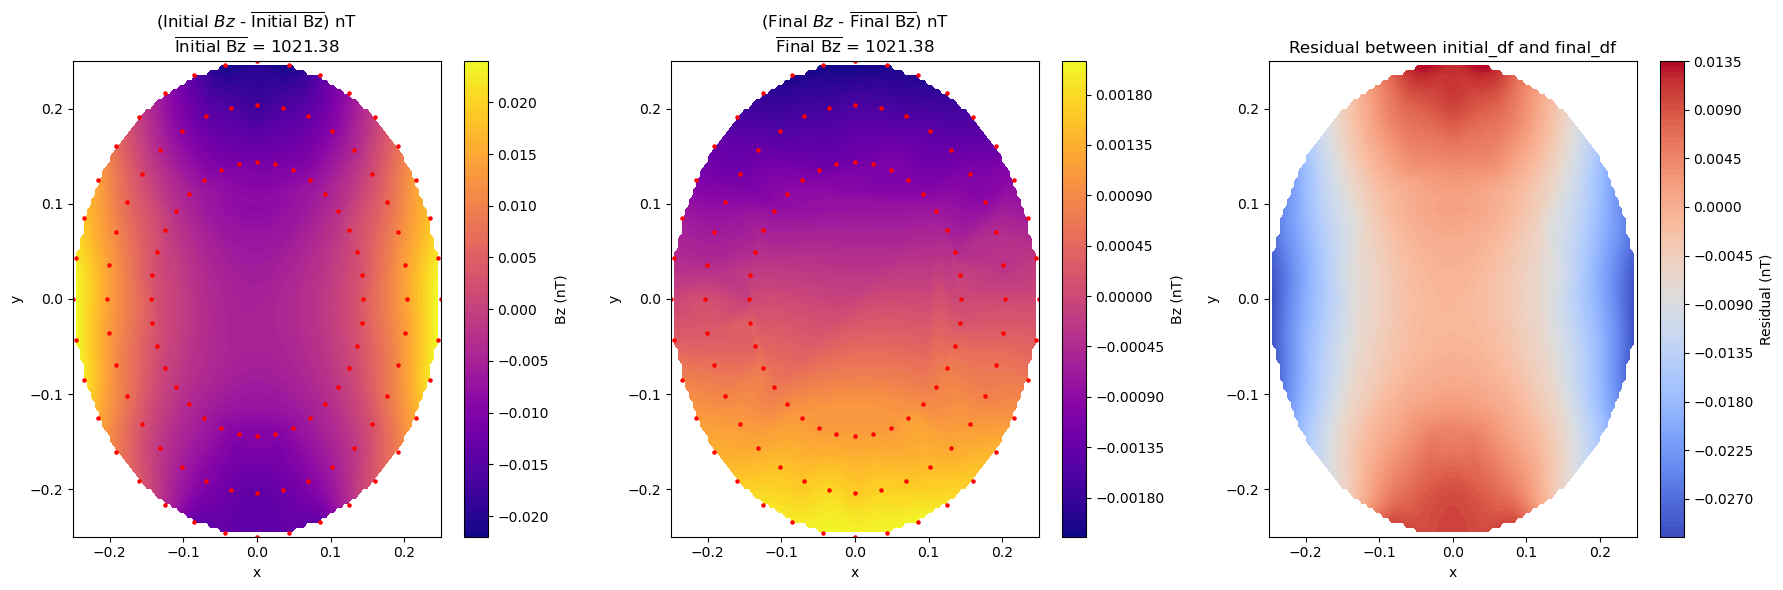

In [22]:

def plot_contour_for_z(df, grid_x, grid_y, ax, title, data):
    df_contour = df[df['z'] == 0]
    grid_Bz = griddata(
        (df_contour['x'], df_contour['y']),
        data[df['z'] == 0]['Bz'],
        (grid_x, grid_y),
        method='cubic'
    )
    contour = ax.contourf(grid_x, grid_y, grid_Bz, levels=100, cmap='plasma')
    fig.colorbar(contour, ax=ax, label='Bz (nT)')
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.scatter(df_contour['x'], df_contour['y'], color='red', s=5)


mean_initial = initial_df[initial_df['z'] == 0]['Bz'].mean()
mean_final = final_df[final_df['z'] == 0]['Bz'].mean()


initial_df_mean_adjusted = initial_df.copy()
initial_df_mean_adjusted['Bz'] -= mean_initial

final_df_mean_adjusted = final_df.copy()
final_df_mean_adjusted['Bz'] -= mean_final
residual_df = final_df.copy()
residual_df['Bz'] -= initial_df['Bz']

# Create grid for interpolation
grid_x, grid_y = np.mgrid[
    min(initial_df['x']):max(initial_df['x']):100j,
    min(initial_df['y']):max(initial_df['y']):100j
]


fig, axs = plt.subplots(1, 3, figsize=(18, 6))

plot_contour_for_z(initial_df, grid_x, grid_y, axs[0],
                   f'(Initial $Bz$ - $\overline{{\mathrm{{Initial\ Bz}}}}$) nT\n'
                   f'$\overline{{\mathrm{{Initial\ Bz}}}}$ = {mean_initial:.2f}',
                   initial_df_mean_adjusted)


plot_contour_for_z(final_df, grid_x, grid_y, axs[1],
                   f'(Final $Bz$ - $\overline{{\mathrm{{Final\ Bz}}}}$) nT\n'
                   f'$\overline{{\mathrm{{Final\ Bz}}}}$ = {mean_final:.2f}',
                   final_df_mean_adjusted)

grid_residual = griddata(
    (initial_df[initial_df['z'] == 0]['x'], initial_df[initial_df['z'] == 0]['y']),
    residual_df[residual_df['z'] == 0]['Bz'],
    (grid_x, grid_y),
    method='cubic'
)
residual_contour = axs[2].contourf(grid_x, grid_y, grid_residual, levels=100, cmap='coolwarm')
fig.colorbar(residual_contour, ax=axs[2], label='Residual (nT)')
axs[2].set_title('Residual between initial_df and final_df')
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')

plt.tight_layout()
plt.show()

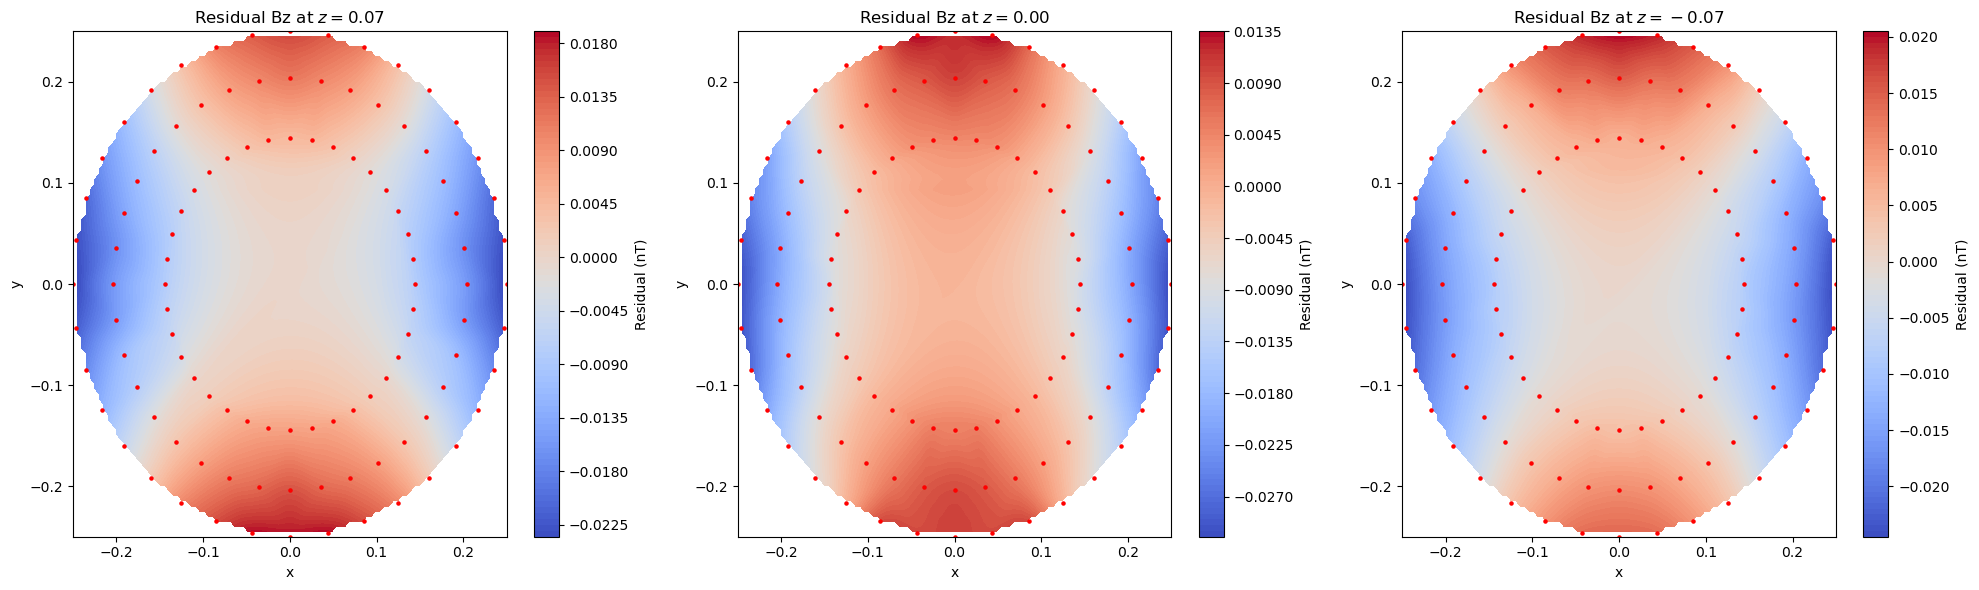

In [23]:
def plot_contour_for_z_residuals(initial_df, final_df, grid_x, grid_y, ax, z_value, title):
    initial_contour = initial_df[initial_df['z'] == z_value]
    final_contour = final_df[final_df['z'] == z_value]
    
    if len(initial_contour) != len(final_contour):
        raise ValueError(f"Mismatched number of (x, y) pairs for z = {z_value}")

    residuals = final_contour['Bz'].values - initial_contour['Bz'].values

    grid_residuals = griddata(
        (initial_contour['x'], initial_contour['y']),
        residuals,
        (grid_x, grid_y),
        method='cubic'
    )

    contour = ax.contourf(grid_x, grid_y, grid_residuals, levels=100, cmap='coolwarm')
    fig.colorbar(contour, ax=ax, label='Residual (nT)')
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    ax.scatter(initial_contour['x'], initial_contour['y'], color='red', s=5)

z_values_to_plot = [0.15/2, 0, -0.15/2]

df_sample = initial_df
grid_x, grid_y = np.mgrid[
    min(df_sample['x']):max(df_sample['x']):100j, 
    min(df_sample['y']):max(df_sample['y']):100j
]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, z_value in enumerate(z_values_to_plot):
    ax = axes[i]
    plot_contour_for_z_residuals(initial_df, final_df, grid_x, grid_y, ax, z_value, f'Residual Bz at $z = {z_value:.2f}$')

plt.tight_layout()
plt.show()
